#**Setup** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax, mean
import math
from numpy import arange, sin, pi, random
import tensorflow as tf
import keras
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from numpy import arange, sin, pi, random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.integrate as integrate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
import scipy as sp
from scipy.fft import fft, fftfreq
from scipy import signal
import pandas as pd

2021-11-15 03:58:17.888686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 03:58:17.888814: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [75]:
savedir = os.path.join(os.path.realpath(''),'/content/gdrive/MyDrive/Colab Notebooks/Anomaly Detection/Output_Figures/Timestep200')

In [2]:
def plot_series(time, series, series2=[], format="-", start=0, end=None, label=None, label2=None, Title = "", xlabel='Time(ms)', ylabel='Value', grid='True'):
    plt.figure(figsize=(10,6))
    plt.plot(time[start:end], series[start:end], format, label=label)
    if label2:
      plt.plot(time[start:end], series2[start:end], format, label=label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title,fontsize = 16)    
    if label:
        plt.legend(fontsize=12)
    if grid == "True":
      plt.grid(grid)
    plt.rcdefaults()
    plt.rc('axes', titlesize=13)
    plt.savefig(savedir + "/" + Title +".png", transparent=True)
def txt_to_array(dir):
    output = []
    with open(dir) as f:
      lines = f.readlines()
    for l in lines:
      output.append(float(l.replace("\n","")))
    return output
def normalize(series):
    result = np.array(series)
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result
    
def emg_fft(N, timeseries, Fs):
  high = 20/(Fs/2)
  low = 450/(Fs/2)
  b, a = sp.signal.butter(4, [high,low], btype='bandpass')
  # process EMG signal: filter EMG
  emg_filtered = sp.signal.filtfilt(b, a, timeseries)
  T = 1.0 / Fs
  x = np.linspace(0.0, N*T, N, endpoint=False)
  yf = fft(emg_filtered)
  xf = fftfreq(N, T)[:N//2]
  return xf, 2.0/N * np.abs(yf[0:N//2])

def series_to_sequences (seqs, series, sequence_length):
  for index in range(0, len(series) - sequence_length):
        seqs.append(series[index: index + sequence_length])
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x sequence length x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

#**Prepare data** 


In [52]:
# from scipy.io import loadmat
# path = "/content/gdrive/MyDrive/Colab Notebooks/Anomaly Detection/sEMG_Basic_Hand_movements_upatras/Database 1"
# os.chdir(path)
# x = loadmat('male_1.mat')
# print(x)
# print(x['cyl_ch1'].shape)

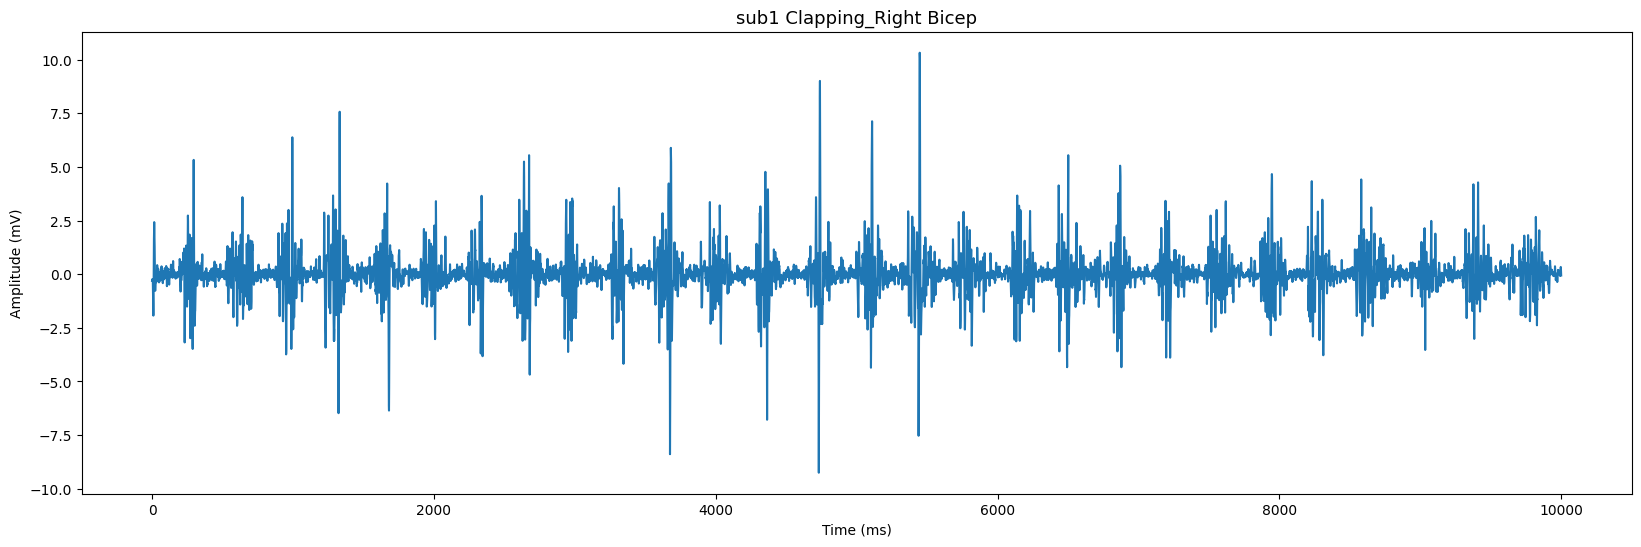

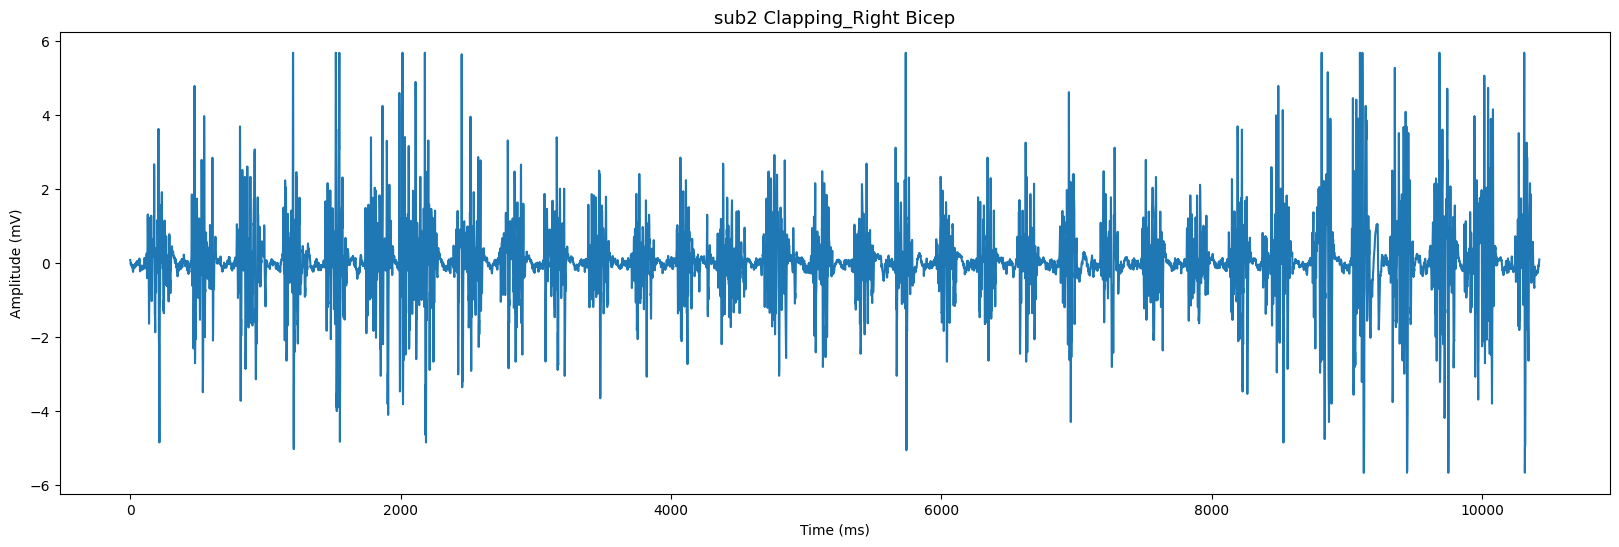

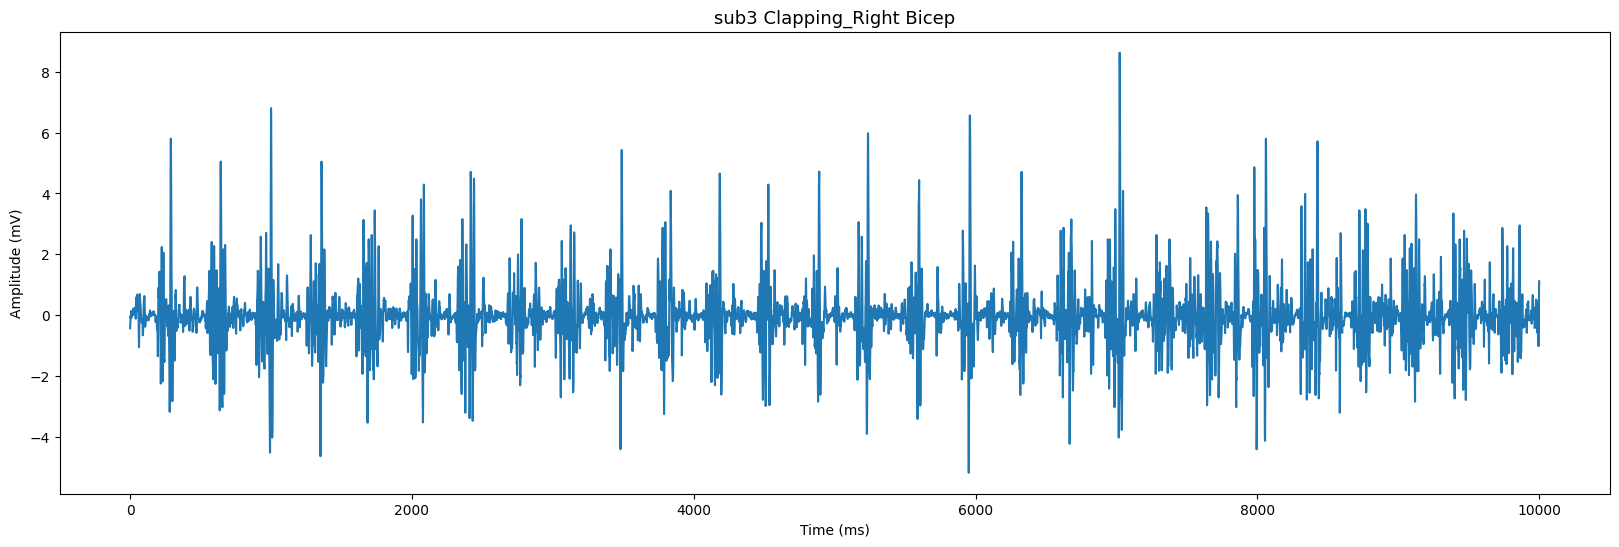

In [59]:
timestep = 150
path = "/content/gdrive/MyDrive/Colab Notebooks/Anomaly Detection/EMG Physical Action Data Set"
os.chdir(path)
emg_clapping_Rbicep = []
for folder in os.listdir():
  if folder != "readme.txt":
    subpath = path + "/" + folder + "/Normal/txt/Clapping.txt"
    data = normalize(np.loadtxt(subpath)[:, 0])
    plt.figure(figsize=(20, 6))
    plt.plot(normalize(data))
    plt.ylabel("Amplitude (mV)")
    plt.xlabel("Time (ms)")
    plt.title(folder + " Clapping_Right Bicep")
    series_to_sequences(emg_clapping_Rbicep, data, timestep)

In [63]:
emg_clapping_Rbicep = np.array(emg_clapping_Rbicep)
print(emg_clapping_Rbicep.shape)

X_train = emg_clapping_Rbicep[:, :-1]
y_train = emg_clapping_Rbicep[:, -1]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(29975, 150)
(29975, 149, 1)
(29975,)


In [64]:
DATA_SPLIT_PCT = 0.2
batch_size = 128
epochs = 20

timesteps =  X_train.shape[1] # equal to the sequence_length
n_features =  X_train.shape[2] # 1
print('Features: ', n_features)
print('Timestep: ',timesteps)

Features:  1
Timestep:  149


#**Build Model**

In [65]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(RepeatVector(timesteps))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
#model.compile(loss='mse', optimizer='adam')
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
model.summary()
	# fit network

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 143, 64)           512       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 137, 64)           28736     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 34, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2176)              0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 149, 2176)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 149, 100)          910800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 149, 100)         

In [66]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
     "/content/gdrive/MyDrive/Colab Notebooks/Anomaly Detection/Model/emg_conv_lstm_ae.h5", save_best_only=True)
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],)
model.save('/content/gdrive/MyDrive/Colab Notebooks/Anomaly Detection/Model/emg_conv_lstm_ae_timestep200.h5')

Epoch 1/20
188/188 [==============================] - 490s 3s/step - loss: 0.3235 - mae: 0.5788 - val_loss: 0.3235 - val_mae: 0.5839
Epoch 2/20
188/188 [==============================] - 487s 3s/step - loss: 0.2825 - mae: 0.5296 - val_loss: 0.2446 - val_mae: 0.4920
Epoch 3/20
188/188 [==============================] - 487s 3s/step - loss: 0.2055 - mae: 0.4376 - val_loss: 0.1487 - val_mae: 0.3720
Epoch 4/20
188/188 [==============================] - 487s 3s/step - loss: 0.1433 - mae: 0.3555 - val_loss: 0.0993 - val_mae: 0.2936
Epoch 5/20
188/188 [==============================] - 487s 3s/step - loss: 0.1075 - mae: 0.3005 - val_loss: 0.1047 - val_mae: 0.2978
Epoch 6/20
188/188 [==============================] - 488s 3s/step - loss: 0.0897 - mae: 0.2706 - val_loss: 0.0747 - val_mae: 0.2432
Epoch 7/20
188/188 [==============================] - 488s 3s/step - loss: 0.0719 - mae: 0.2408 - val_loss: 0.0418 - val_mae: 0.1848
Epoch 8/20
188/188 [==============================] - 490s 3s/step - 

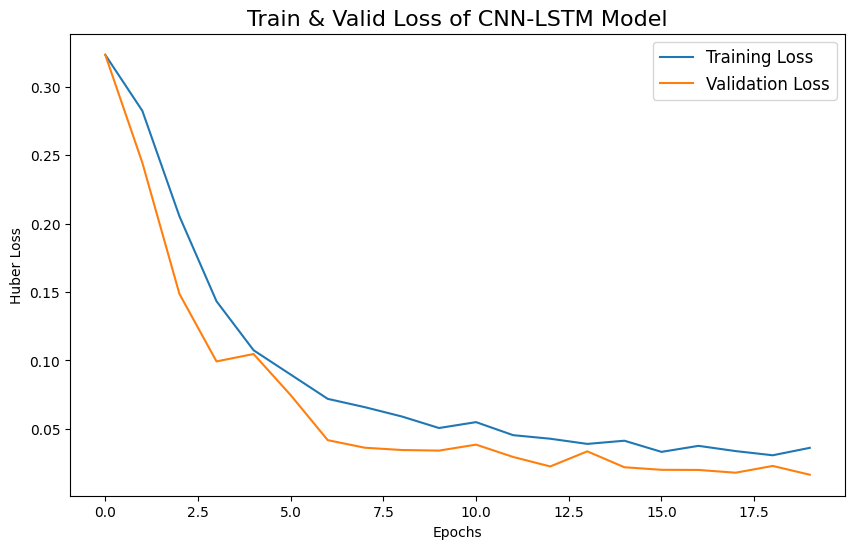

In [67]:
plot_series(range(0,epochs), history.history["loss"], history.history["val_loss"], label="Training Loss", label2="Validation Loss", Title = "Train & Valid Loss of CNN-LSTM Model", xlabel="Epochs", ylabel="Huber Loss", grid="False")


In [68]:
model = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Anomaly Detection/Model/emg_conv_lstm_ae.h5')

In [76]:
x_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(x_train_pred - X_train), axis=1)

ValueError: ignored

Max Mae Loss 0.8843842278913966


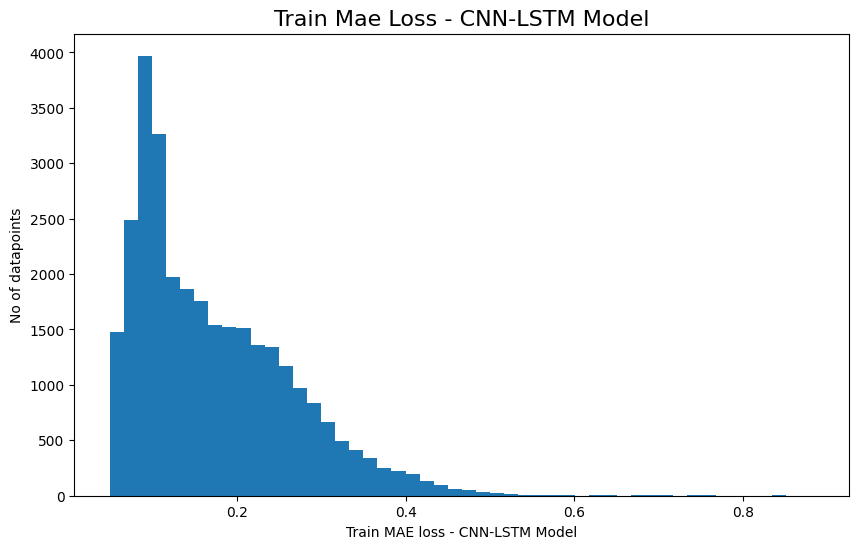

In [71]:
plt.figure(figsize=(10,6))
plt.hist(train_mae_loss, bins=50)
plt.title('Train Mae Loss - CNN-LSTM Model', fontsize = 16)
plt.rcdefaults()
plt.rc('axes', titlesize=13)
plt.xlabel("Train MAE loss - CNN-LSTM Model")
plt.ylabel("No of datapoints")
plt.savefig(savedir + "/Train Mae Loss_CNN LSTM Model_epoch20_timestep100.png", transparent=True)
print("Max Mae Loss", np.max(train_mae_loss))

In [72]:
train_loss = tf.keras.losses.mae(x_train_pred, X_train)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Mean mae loss", np.mean(train_loss))
print("Std mae loss",  np.std(train_loss))
print("Threshold: ", threshold)

InvalidArgumentError: ignored

#**Test Model**

## **Test set 1**

### Read data

In [ ]:
dir = os.path.join(os.path.realpath(''),'/content/gdrive/MyDrive/Đồ án 3/Data/graphene_emg_test.txt')
emg_test = txt_to_array(dir)
emg_test_normalize = normalize(emg_test)
plot_series(range(0,len(emg_test_normalize)),emg_test_normalize, Title="EMG Test Set (EMG Signal with Graphene)", ylabel="mV")

In [ ]:
data_test = []
series_to_sequences(data_test, emg_test_normalize, timestep)
data_test = np.array(data_test)
X_test = data_test[:, :-1]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
x_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(x_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(test_mae_loss, bins=50)
plt.title('Test Mae Loss - CNN-LSTM Model', fontsize = 16)
plt.rcdefaults()
plt.rc('axes', titlesize=13)
plt.ylabel("No of datapoints")
plt.xlabel("Test MAE loss - CNN-LSTM Model")
plt.savefig(savedir + "/Test Mae Loss_EMG Signal with Graphene_CNN-LSTM Model.png", transparent = True)

In [ ]:
emgtest_pred = flatten(x_test_pred).flatten()
print(emgtest_pred.shape)
print(emg_test_normalize.shape)

In [ ]:
plot_series(range(0,24900),emg_test_normalize[0:24900], emgtest_pred, Title="EMG test & Reconstructed EMG test by CNN-LSTM Model", ylabel='Amplitude(mV', label="EMG test", label2='Reconstructed EMG test')


### Frequency

In [ ]:
x_train_fft, y_train_fft = emg_fft(10000, emgtrained_pred, 1000 )
plt.figure(figsize=(12, 8))
plt.plot(x_train_fft, y_train_fft)
plt.xlabel("Frequency")
plt.ylabel("FFT Unit")
plt.title("Frequency Domain of predicted X_train")

### **Anomaly Detection**

In [ ]:
print("Threshold = ", threshold)

In [ ]:
anomalies = test_mae_loss > threshold
print("Number of detected anomaly samples: ", np.sum(anomalies))
anomalies = np.array(anomalies)
anomalies_index = []

for i in range(0,len(anomalies)):
  if anomalies[i] == True:
    anomalies_index.append(i + 100)


In [ ]:
plot_series(range(0,len(emg_test_normalize)),emg_test_normalize, Title="Anomalies in test set (CNN-LSTM Model)", ylabel="mV")
plt.plot(anomalies_index,emg_test_normalize[anomalies_index], 'o', color='red')
plt.savefig(savedir + "/" + "Anomalies in test set (CNN-LSTM Model)"+".png", transparent=True)

## **Test set 2**

In [ ]:
dir = os.path.join(os.path.realpath(''),'/content/gdrive/MyDrive/Đồ án 3/Data/graphene_emg_test2.txt')
emg_test2 = txt_to_array(dir)
emg_test2_normalize = normalize(emg_test2)
plot_series(range(0,len(emg_test2_normalize)),emg_test2_normalize, Title="EMG Test Set 2 (50Hz)", ylabel="mV")


In [ ]:
x_test2_fft, y_test2_fft = emg_fft(4000, emg_test2_normalize, 1000 )
plt.figure(figsize=(10, 6))
plt.plot(x_test2_fft, y_test2_fft)
plt.xlabel("Frequency")
plt.ylabel("FFT Unit")
plt.title("Frequency Domain of EMG test set 2 (50Hz)")

In [ ]:
data_test = []
series_to_sequences(data_test, emg_test2_normalize, timestep)
data_test = np.array(data_test)
X_test2 = data_test[:, :-1]
X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 1))

In [ ]:
x_test2_pred = model.predict(X_test2)
test_mae_loss2 = np.mean(np.abs(x_test2_pred - X_test2), axis=1)
test_mae_loss2 = test_mae_loss2.reshape((-1))


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(test_mae_loss2, bins=50)
plt.title('Test Mae Loss (TestSet2) - CNN-LSTM Model', fontsize = 16)
plt.rcdefaults()
plt.rc('axes', titlesize=13)
plt.ylabel("No of datapoints")
plt.xlabel("Test MAE loss - CNN-LSTM Model")
plt.savefig(savedir + "/Test Mae Loss_Test Set 2 50Hz_CNN-LSTM Model.png", transparent = True)

In [ ]:
emgtest2_pred = flatten(x_test2_pred).flatten()
print(emgtest2_pred.shape)
print(emg_test2_normalize.shape)

In [ ]:
plot_series(range(0,3900),emg_test2_normalize[0:3900], emgtest2_pred, Title="EMG test & Reconstructed EMG test 2 (50Hz) by CNN-LSTM Model", ylabel='Amplitude(mV', label="EMG test", label2='Reconstructed EMG test')


## **Anomaly Detection**

In [ ]:
print("Threshold = ", threshold)

In [ ]:
anomalies2 = test_mae_loss2 > threshold
print("Number of detected anomaly samples: ", np.sum(anomalies2))
anomalies2 = np.array(anomalies2)
anomalies2_index = []

for i in range(0,len(anomalies2)):
  if anomalies2[i] == True:
    anomalies2_index.append(i + 100)


In [ ]:
plot_series(range(0,len(emg_test2_normalize)),emg_test2_normalize, Title="Anomalies in test set 2 50Hz (CNN-LSTM Model)", ylabel="mV")
plt.ylim([-3, 1.5])
plt.plot(anomalies2_index,emg_test2_normalize[anomalies2_index], 'ro', markersize=2)

#plt.scatter(anomalies2_index,emg_test2_normalize[anomalies2_index], s=3)
plt.savefig(savedir + "/" + "Anomalies in test set 2 50Hz (CNN-LSTM Model)"+".png", transparent=True)